# **Projeto 4 introdução a redes neurais - Redes Recorrentes**

-------------------------------------------------------------------------------------------------------------

## Objetivo: 

Classificar séries temporais, onde o modelo recebe uma janela de dados e identifica sua categoria com base nos padrões observados. O objetivo escolhido para o projeto será classificar um segmento de ECG em normal, arritmia, etc...

## Dataset

O **MIT-BIH Arrhythmia** é um dataset de série temporal contendo gravações de ECG de pacientes com diferentes tipos de arritmias. A tarefa é classificar os batimentos cardíacos com base nos sinais ao longo do tempo. Cada amostra consiste em segmentos de ECG rotulados, representando diferentes classes de batimentos. A ordem dos registros é essencial, pois os dados são sequenciais. O objetivo é identificar e classificar corretamente os tipos de batimentos cardíacos a partir dos sinais de ECG.

## Importação das bibliotecas necessárias

In [10]:
import wfdb
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Preparação dos dados

#### 1. Carregamento do Dataset  
- O arquivo **ECG (mit-bih-arrhythmia-database-1.0.0)** foi carregado a partir do diretório do projeto utilizando a função `wfdb.rdrecord()` da biblioteca `wfdb`.  
- O dataset contém **sinais de ECG** com informações de **tempo e rótulos de classes** que indicam tipos de arritmia ou a ausência delas.

#### 2. Separação dos Conjuntos  
- Os dados foram divididos em **treinamento (80%)** e **teste (20%)** utilizando a função `train_test_split()` do Scikit-learn.  
- Distribuição final dos dados:  
  - **Treino:** 8.000 amostras  
  - **Teste:** 2.000 amostras  

#### 3. Normalização e Formatação dos Dados  
- Os sinais de ECG foram convertidos para **float32** e normalizados, garantindo que os valores numéricos estivessem no formato adequado para o treinamento do modelo.  
- A variável alvo (tipo de arritmia) foi convertida para **representação categórica** (classes conforme o sinal de ECG).  
- Os dados de entrada foram remodelados para o formato adequado ao modelo **LSTM**, com uma **dimensão adicional** para representar as séries temporais.

#### 4. Visualização dos Dados  
- Foram exibidos **5 exemplos do conjunto de treino** com seus respectivos rótulos (tipos de arritmia ou ausência), permitindo uma verificação visual dos padrões nas séries temporais de ECG antes do treinamento.


Tamanho do treino: (2232, 100), (2232,)
Tamanho do teste: (559, 100), (559,)


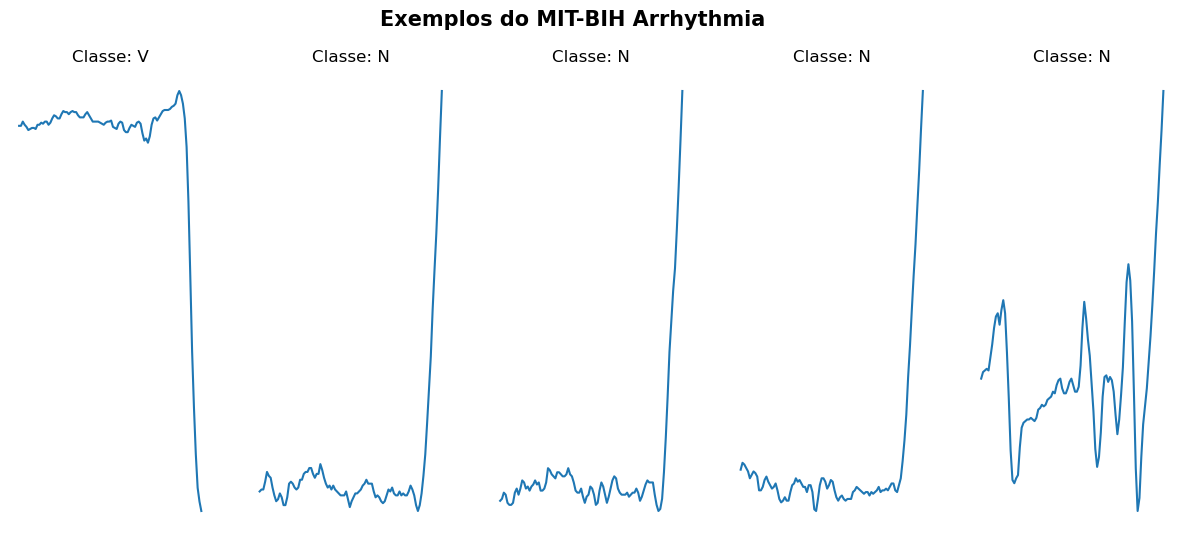

In [11]:
# Definir o caminho da pasta do dataset
DATASET_PATH = "./mit-bih-arrhythmia-database-1.0.0"

# Listar arquivos de registros disponíveis
records = [f.split(".")[0] for f in os.listdir(DATASET_PATH) if f.endswith(".dat")]

# Definir uma amostra de registros para processamento
selected_record = records[0]  # Usaremos o primeiro como exemplo

# Carregar os sinais e anotações
record = wfdb.rdrecord(os.path.join(DATASET_PATH, selected_record))
annotation = wfdb.rdann(os.path.join(DATASET_PATH, selected_record), "atr")

# Extrair sinais e rótulos
signals = record.p_signal  # Sinais de ECG (duas derivações)
labels = annotation.sample  # Posições dos batimentos
classes = annotation.symbol  # Tipos de batimentos

# Normalizar os sinais para intervalo [-1, 1]
signals = (signals - np.mean(signals)) / np.std(signals)

# Criar janelas de entrada para o modelo
window_size = 100  # Tamanho da janela 
X, y = [], []
for i in range(len(labels)):
    if labels[i] >= window_size:
        X.append(signals[labels[i] - window_size: labels[i], 0])  
        y.append(classes[i])

X = np.array(X)
y = np.array(y)

# Separar treino e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=42)

# Exibir os tamanhos dos conjuntos
print(f"Tamanho do treino: {X_treino.shape}, {y_treino.shape}")
print(f"Tamanho do teste: {X_teste.shape}, {y_teste.shape}")

# Visualizar algumas amostras
plt.figure(figsize=(15, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.plot(X_treino[i])
    plt.title(f"Classe: {y_treino[i]}")
    plt.axis('off')
plt.suptitle("Exemplos do MIT-BIH Arrhythmia", fontsize=15, fontweight='bold')
plt.show()